<a href="https://colab.research.google.com/github/asoushawk/octopusguesser/blob/master/modeltest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
!pip install -q sklearn

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import time

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [4]:
# Load dataset.
dftrain = pd.read_csv('http://unes.epizy.com/treino.csv') # training data
dfeval = pd.read_csv('testsample.csv') # testing data
eval = pd.read_csv('testsample.csv')
y_train = dftrain.pop('winner')
print(dftrain.head())
y_eval = dfeval.pop('winner')
print(dfeval.head())


  top_red_champion  ...  sup_blue_champion_kda
0            Yasuo  ...               6.700000
1         Renekton  ...               6.700000
2         Renekton  ...               2.483333
3         Malphite  ...               2.526316
4            Fiora  ...               2.153846

[5 rows x 30 columns]
  top_red_champion  ...  sup_blue_champion_kda
0            Diana  ...               0.750000
1            Riven  ...               7.038462
2            Diana  ...               1.700000
3            Vayne  ...               1.700000
4            Akali  ...               8.736559

[5 rows x 30 columns]


In [22]:
CATEGORICAL_COLUMNS = ["top_red_champion", "jg_red_champion", "mid_red_champion",
                       "adc_red_champion", "sup_red_champion",
                       "top_blue_champion", "jg_blue_champion", "mid_blue_champion",
                       "adc_blue_champion", "sup_blue_champion"]
NUMERIC_COLUMNS = ["top_red_rota_champion_month", "top_red_champion_kda",  
"top_blue_rota_champion_month", "top_blue_champion_kda", 
"jg_red_rota_champion_month",  "jg_red_champion_kda", 
"jg_blue_rota_champion_month",  "jg_blue_champion_kda", 
"mid_red_rota_champion_month", "mid_red_champion_kda", 
"mid_blue_rota_champion_month",  "mid_blue_champion_kda",
"adc_red_rota_champion_month",  "adc_red_champion_kda",
"adc_blue_rota_champion_month",  "adc_blue_champion_kda",
"sup_red_rota_champion_month",  "sup_red_champion_kda",
"sup_blue_rota_champion_month",  "sup_blue_champion_kda"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(list(feature_columns[1]))

['jg_red_champion', ('Nocturne', 'Graves', 'Diana', 'Lee Sin', 'Kayn', 'Brand', 'Kindred', 'Ekko', 'Evelynn', 'Nidalee', 'Jax', 'Shaco', 'Amumu', 'Warwick', "Kha'Zix", 'Akali', 'Sylas', "Vel'Koz", 'Nasus', 'Gragas', 'Master Yi', 'Hecarim', 'Malphite', 'Udyr', 'Vi', 'Xin Zhao', 'Wukong', 'Volibear', "Rek'Sai", 'Kassadin', 'Fiddlesticks', 'Qiyana', 'Shyvana', 'Ziggs', 'Caitlyn', 'Nami', 'Rengar', 'Lillia', 'Miss Fortune', 'Taliyah', 'Zoe', 'Ornn', 'Lulu', 'Jinx', 'Ashe', 'Janna', 'Kennen'), tf.string, -1, 0]


In [6]:
dftrain.head()

,top_red_champion,top_red_rota_champion_month,top_red_champion_kda,top_blue_champion,top_blue_rota_champion_month,top_blue_champion_kda,jg_red_champion,jg_red_rota_champion_month,jg_red_champion_kda,jg_blue_champion,jg_blue_rota_champion_month,jg_blue_champion_kda,mid_red_champion,mid_red_rota_champion_month,mid_red_champion_kda,mid_blue_champion,mid_blue_rota_champion_month,mid_blue_champion_kda,adc_red_champion,adc_red_rota_champion_month,adc_red_champion_kda,adc_blue_champion,adc_blue_rota_champion_month,adc_blue_champion_kda,sup_red_champion,sup_red_rota_champion_month,sup_red_champion_kda,sup_blue_champion,sup_blue_rota_champion_month,sup_blue_champion_kda
0,Yasuo,42.3,8.120896,Volibear,50.0,6.363636,Nocturne,42.9,13.000000,Diana,51.8,4.331343,Malphite,53.8,8.000000,Annie,51.9,7.388889,Jinx,50.0,12.428571,Senna,53.6,10.651282,Pyke,51.5,9.482759,Taric,51.5,6.700000
1,Renekton,100.0,5.400000,Volibear,43.8,4.755319,Graves,72.7,6.300000,Master Yi,58.7,4.331343,Akali,43.8,10.692308,Diana,51.9,10.692308,Jhin,42.9,9.273913,Senna,53.6,10.651282,Pantheon,63.6,11.874074,Taric,53.1,6.700000
2,Renekton,55.2,6.242553,Jax,53.7,8.152174,Diana,42.9,10.500000,Kayn,68.8,4.331343,Annie,51.9,7.388889,Lucian,42.9,7.388889,Senna,53.6,10.651282,Vayne,51.4,7.358333,Taric,53.1,6.700000,Leona,50.0,2.483333
3,Malphite,60.0,5.175000,Gangplank,50.0,4.448276,Lee Sin,100.0,22.000000,Graves,27.3,3.937500,Neeko,51.9,9.047761,Yasuo,37.5,9.047761,Senna,53.6,10.651282,Twitch,50.8,11.266667,Alistar,53.1,5.583784,Brand,42.9,2.526316
4,Fiora,50.0,6.271698,Darius,43.8,11.230769,Kayn,53.3,13.559155,Shyvana,40.9,6.681818,Yasuo,56.1,12.533333,Katarina,40.9,12.533333,Samira,53.6,8.000000,Kog'Maw,30.4,4.454545,Taric,53.1,6.700000,Leona,50.0,2.153846


input function

In [23]:
def make_input_fn(data_df, label_df, num_epochs=2000, shuffle=False, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(2000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [24]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmph7os6c1a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7407407


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplxpayrhb/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


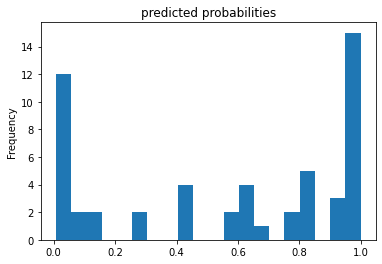

In [10]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [18]:
result = list(linear_est.predict(eval_input_fn))
p = 0
redwincount = 0
bluewincount = 0
erros = 0
acertos = 0

for _ in range(54):

  #redteam nomedoscampeões:
  top_red = eval.iat[p,0]
  jg_red = eval.iat[p,6]
  mid_red = eval.iat[p,12]
  adc_red = eval.iat[p,18]
  sup_red = eval.iat[p,24]

  top_blue = eval.iat[p,3]
  jg_blue = eval.iat[p,9]
  mid_blue = eval.iat[p,15]
  adc_blue = eval.iat[p,21]
  sup_blue = eval.iat[p,27]

  
  winner_ = eval.iat[p,30]
  print("Partida - ", p)
  print("Time Vermelho =",
        "Top:", top_red, "-",
        "Jungler:", jg_red, "-",
        "Mid:", mid_red, "-",
        "ADC:", adc_red, "-",
        "Sup", sup_red, "-") 
  
  print("Time Azul =",
        "Top:", top_blue, "-",
        "Jungler:", jg_blue, "-",
        "Mid:", mid_blue, "-",
        "ADC:", adc_blue, "-",
        "Sup", sup_blue)

  a = float(result[p]['probabilities'][1])
  b = float(result[p]['probabilities'][0])
  resultblue = round(a,3)
  resultred = round(b,3)
  print(resultblue * 100, "% de chance do time azul vencer")
  print(resultred * 100, "% de chance do time vermelho vencer")
  
  p = p + 1
  print("Acho que o vencedor foi o:", winner_)
 
  
  if resultred > 0.500000: #o que o bot acha em relação ao resultado
    redwincount = redwincount + 1
    print("Bluewincount:", bluewincount)
    print("Redwincount:", redwincount)
    if winner_ != 0: #teste explicíto de se acertou ou não
      print("Eu errei, meeeeeeeee")
      erros = erros + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
    else:
      print("Hmmm analizando o resultado real da partida, eu acertei hihi")
      acertos = acertos + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)

    
  else:
     bluewincount = bluewincount + 1
     print("Bluewincount:", bluewincount)
     print("Redwincount:", redwincount)
     if winner_ != 1:
      print("Eu errei, meeeeeeeeeeeeeee")
      erros = erros + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
     else:
      print("Hmmm analizando o resultado real da partida, eu acertei hihi")
      acertos = acertos + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
     
  
  







INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplxpayrhb/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Partida -  0
Time Vermelho = Top: Diana - Jungler: Udyr - Mid: Fiora - ADC: Irelia - Sup Soraka -
Time Azul = Top: Rumble - Jungler: Evelynn - Mid: Katarina - ADC: Tristana - Sup Rakan
99.6 % de chance do time azul vencer
0.4 % de chance do time vermelho vencer
Acho que o vencedor foi o: 0
Bluewincount: 1
Redwincount: 0
Eu errei, meeeeeeeeeeeeeee
Total de erros: 1
Total de acertos: 0
Partida -  1
Time Vermelho = Top: Riven - Jungler: Rek'Sai - Mid: Akali - ADC: Jhin - Sup Alistar -
Time Azul = Top: Sett - Jungler: Hecarim - Mid: Yasuo - ADC: Varus - Sup Brand
42.199999999999996 % de chance do time azul vencer
57.8 % de chance do time vermelho vencer
Acho que o vencedor foi o: 1
Bluewincount: 1
Redwincount: 1
Eu errei, meeeeeeeee
Total de erros: 2
Total de 